In [1]:
import rioxarray
import rasterio
import numpy as np
import qinfer
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import geopandas as gpd
from shapely.geometry.point import Point
import shapely.affinity
import subprocess
from osgeo import gdal
import pygeos
import json
import os
import pandas as pd
from tqdm import tqdm
import requests
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import esda
import libpysal
from scipy import stats

/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/qinfer/parallel.py:51: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  warnings.warn(


In [5]:
cwd = os.getcwd()
input_path = 'NID_FIM_TAS_Breach'
scenarios = {'loadCondition': 'TAS', 'breachCondition': 'F'}
output_path = 'output'

dam_id = 'TX00018'

In [3]:
census_gdf = gpd.read_file(os.path.join(cwd, 'census_geometry', 'tl_2020_block_texas.geojson'))

# Clean census_gdf for having GEOID column and geometry in EPSG:4326
if 'GEOID' in census_gdf.columns:
    pass
elif 'geoid' in census_gdf.columns:
    census_gdf.rename(columns={'geoid': 'GEOID'}, inplace=True) # Comment this line for `tl_2020_tabblock20.geojson`
else:
    raise AttributeError('either GEOID or geoid column is necessary')

if census_gdf.crs != 'EPSG:4326':
    census_gdf = census_gdf.to_crs(epsg=4326)
    
census_gdf = census_gdf[['GEOID', 'geometry']]
census_gdf.head(1)

,GEOID,geometry
0,480679503001009,"POLYGON ((-94.15007 33.16598, -94.15003 33.166..."


In [7]:
def resample_raster(rasterfile_path, filename, target_path, rescale_factor):
    # first determine pixel size for resampling
    xres = 0
    yres = 0
    
    out = subprocess.run(["gdalinfo","-json",rasterfile_path],stdout=subprocess.PIPE)
    raster_meta = json.loads(out.stdout.decode('utf-8'))
    if 'geoTransform' in raster_meta:
        xres = raster_meta['geoTransform'][1]
        yres = raster_meta['geoTransform'][5]
        xres = xres * rescale_factor
        yres = yres * rescale_factor

    if (xres != 0) and (yres != 0):
        # resample raster
        save_path = target_path +"/"+ filename + f"_resample_{rescale_factor}.tiff"
        subprocess.run(["gdalwarp","-r","bilinear","-of","GTiff","-tr",str(xres),str(yres),rasterfile_path,save_path])

        return save_path


# reclassify, resample, and polygonize raster flood inundation map
def polygonize_fim(rasterfile_path):

    # Extract target path and filename from the given raster file path
    target_path = '/'.join(rasterfile_path.split('/')[:-1])
    filename = rasterfile_path.split("/")[-1].split(".")[-2]

    # Resample raster file to 10-times smaller
    resample_10_path = resample_raster(rasterfile_path, filename, target_path, rescale_factor=10)

    # Reclassify raster
    '''
    water_lvl = [0, 2, 6, 15, np.inf]  # Original inundation map value (underwater in feet)
    water_lvl_recls = [-9999, 1, 2, 3, 4]
    '''
    reclass_file = target_path + "/" + filename + "_reclass.tiff"
    outfile = "--outfile="+reclass_file
    subprocess.run(["gdal_calc.py","-A",resample_10_path,outfile,"--calc=-9999*(A<=0)+1*((A>0)*(A<=2))+2*((A>2)*(A<=6))+3*((A>6)*(A<=15))+4*(A>15)","--NoDataValue=-9999"],stdout=subprocess.PIPE)

    # Polygonize the reclassified raster
    geojson_out = "%s/%s.json" % (target_path, filename)
    subprocess.run(["gdal_polygonize.py", reclass_file, "-b", "1", geojson_out, filename, "value"])

    inund_polygons = gpd.read_file(geojson_out)
    inund_polygons = inund_polygons.loc[(inund_polygons['value'] != -9999) & (inund_polygons['value'] != 0)]  # Remove pixels of null value

    # drop invalid geometries
    inund_polygons = inund_polygons.loc[inund_polygons['geometry'].is_valid, :]

    # Coverage for each class of inundation map
    inund_per_cls = inund_polygons.dissolve(by='value')
    inund_per_cls.reset_index(inplace=True)

    # remove all temp files
    os.remove(resample_10_path)
    os.remove(reclass_file)
    os.remove(geojson_out)

    # inundation_per_cls: GeoDataFrame 
    return inund_per_cls

    
def calculate_ellipse_based_on_convex_hull(points_ary):
    
    # Calculate ellipse (MVEE; minimum-volume enclosing ellipse)
    A, centroid = qinfer.utils.mvee(points_ary)
    U, D, V = la.svd(A)
    
    ## x, y radii.
    rx, ry = 1./np.sqrt(D)

    ## Define major and minor semi-axis of the ellipse.
    dx, dy = 2 * rx, 2 * ry
    ma_axis, mi_axis = max(dx, dy), min(dx, dy)
    
    ## Calculate orientation of ellipse
    arcsin = -1. * np.rad2deg(np.arcsin(V[0][0]))
    arccos = np.rad2deg(np.arccos(V[0][1]))
    # Orientation angle (with respect to the x axis counterclockwise).
    alpha = arccos if arcsin > 0. else -1. * arccos

    ## Create a circle of radius 0.5 around center point:
    circ = shapely.geometry.Point(centroid).buffer(0.5)
    ellipse  = shapely.affinity.scale(circ, ma_axis, mi_axis)
    ellipse_rotate = shapely.affinity.rotate(ellipse, alpha)
    
    return ellipse_rotate
    

def extract_inundated_area_geoid(input_dir, census_gdf, dam_id, scene):
    
    fim_path = f"./{input_dir}/{scenarios['loadCondition']}_{scenarios['breachCondition']}_{dam_id}.tiff"

    # Destination dataframe to save the results
    fim_geoid_df = pd.DataFrame({'Dam_ID': pd.Series(dtype='str'),
                                'Scenario': pd.Series(dtype='str'),
                                'GEOID': pd.Series(dtype='str'),
                                'Class': pd.Series(dtype='str')}
                                )        

    print(f"{dam_id}: 1/4, Polygonizing inundation map")
    fim_gdf = polygonize_fim(fim_path)
    fim_gdf['Dam_ID'] = dam_id
    fim_gdf['Scenario'] = f"{scene['loadCondition']}_{scene['breachCondition']}"

    # Create STRtree for census_gdf
    print(f"{dam_id}: 2/4, Extracting inundated census blocks")
    census_geoms = pygeos.from_shapely(census_gdf['geometry'].values)
    census_geoms_tree = pygeos.STRtree(census_geoms, leafsize=50)

    # Extract census tract intersecting with each class of inundation map
    for water_cls in fim_gdf['value'].unique():
        inund_per_cls_geom = pygeos.from_shapely(fim_gdf.loc[fim_gdf['value'] == water_cls, 'geometry'].values[0])
        query_inund_census_geom = census_geoms_tree.query(inund_per_cls_geom, predicate='intersects')
        inund_census_gdf = census_gdf.loc[query_inund_census_geom]

        for geoid_ in inund_census_gdf['GEOID'].to_list():
            new_row = pd.DataFrame({'Dam_ID': dam_id, 
                                    'Scenario': f"{scene['loadCondition']}_{scene['breachCondition']}", 
                                    'GEOID': geoid_, 
                                    'Class': water_cls}, 
                                    index=[0]
                                    )
            fim_geoid_df = pd.concat([new_row, fim_geoid_df]).reset_index(drop=True)
    
    # Caclulate minimum-volume enclosing ellipse (mvee) of the inundation map to extract benchmark area
    print(f"{dam_id}: 3/4, Extracting benchmark area")
    
    # Collecting points from convex hull of the inundation map
    # These points will be used for calculating mvee 
    convex_hull_pnts = np.array(fim_gdf.unary_union.convex_hull.exterior.coords)   
    ellipse = calculate_ellipse_based_on_convex_hull(convex_hull_pnts)
    ellipse_gdf = gpd.GeoDataFrame({'Dam_ID':f'{dam_id}'}, index=[0], geometry=[ellipse], crs='EPSG:4326')
    
    # Extract benchmark area (not inundated) intersecting with the ellipse
    ellipse_geom = pygeos.from_shapely(ellipse)    
    query_benchmark_census_geom = census_geoms_tree.query(ellipse_geom, predicate='intersects')
    benchmark_census_gdf = census_gdf.loc[query_benchmark_census_geom]

    for geoid_ in benchmark_census_gdf['GEOID'].to_list():
        new_row = pd.DataFrame({'Dam_ID': dam_id, 
                                'Scenario': f"{scene['loadCondition']}_{scene['breachCondition']}", 
                                'GEOID': geoid_, 
                                'Class': 0
                                }, index=[0]
                                )
        fim_geoid_df = pd.concat([new_row, fim_geoid_df]).reset_index(drop=True)

    print(f"{dam_id}: 4/4, Assigning geometry to census blocks")
    fim_geoid_gdf = fim_geoid_df.merge(census_gdf, on='GEOID')
    fim_geoid_gdf = gpd.GeoDataFrame(fim_geoid_gdf, geometry=fim_geoid_gdf['geometry'], crs='EPSG:4326')
    fim_geoid_gdf['Class'] = fim_geoid_gdf['Class'].astype(int)
    fim_geoid_gdf = fim_geoid_gdf.groupby(['Dam_ID', 'Scenario', 'GEOID'], 
                                    group_keys=False).apply(lambda x:x.loc[x['Class'].idxmax()]
                                                            ).reset_index(drop=True)

    return fim_geoid_gdf, fim_gdf, ellipse_gdf


fim_geoid, fim, ellipse = extract_inundated_area_geoid(input_path, census_gdf, dam_id, scenarios)

TX00018: 1/4, Polygonizing inundation map
Creating output file that is 4033P x 3915L.
Processing ./NID_FIM_TAS_Breach/TAS_F_TX00018.tiff [1/1] : 0Using internal nodata values (e.g. -9999) for image ./NID_FIM_TAS_Breach/TAS_F_TX00018.tiff.
Copying nodata values from source ./NID_FIM_TAS_Breach/TAS_F_TX00018.tiff to destination ./NID_FIM_TAS_Breach/TAS_F_TX00018_resample_10.tiff.
...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...Several drivers matching json extension. Using GeoJSON
Creating output ./NID_FIM_TAS_Breach/TAS_F_TX00018.json of format GeoJSON.
100 - done.
TX00018: 2/4, Extracting inundated census blocks
TX00018: 3/4, Extracting benchmark area
TX00018: 4/4, Assigning geometry to census blocks


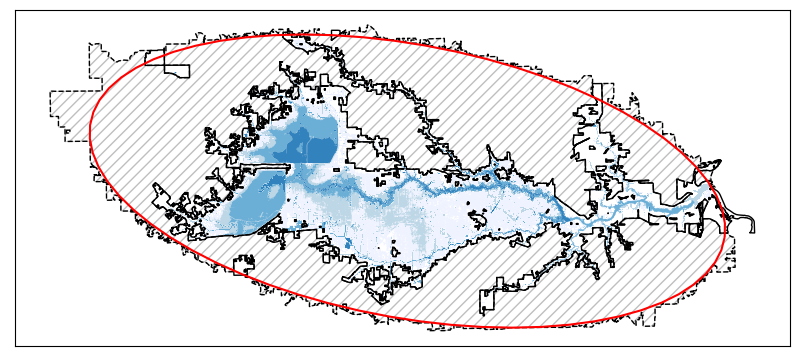

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

color_brewer = ['#eff3ff','#bdd7e7','#6baed6','#3182bd']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=4)

if fim_geoid.crs == None:
    fim_geoid.set_crs(epsg=4326, inplace=True)
    
flood_geom = fim_geoid.loc[(fim_geoid['Class'] != 0) & (fim_geoid['Dam_ID'] == dam_id)]
flood_geom = flood_geom.dissolve(by='Dam_ID')

non_flood_geom = fim_geoid.loc[(fim_geoid['Class'] == 0) & (fim_geoid['Dam_ID'] == dam_id)]
non_flood_geom = non_flood_geom.dissolve(by='Dam_ID')

fim.plot('value', ax=ax, cmap=cm)
flood_geom.boundary.plot(ax=ax, color='black', lw=1)
non_flood_geom.boundary.plot(ax=ax, color='black', lw=1, linestyle='dashed')
non_flood_geom.plot(color='white', edgecolor='grey', linewidth = 0.5, hatch='///', alpha = 0.5, ax=ax)
ellipse.loc[ellipse['Dam_ID'] == dam_id].boundary.plot(ax=ax, color='Red')

ax.get_xaxis().set_visible(False)  # Remove ticks and labels
ax.get_yaxis().set_visible(False)

In [9]:
def call_census_table(state_list, table, key):
    
    result_df = pd.DataFrame()
    
    # querying at census tract level
    for state in tqdm(state_list):
        if table.startswith('group'):
            address = f'https://api.census.gov/data/2020/acs/acs5?get=NAME,{table}&for=tract:*&in=state:{state}&in=county:*'
        elif table.startswith('DP'):
            address = f'https://api.census.gov/data/2020/acs/acs5/profile?get=NAME,{table}&for=tract:*&in=state:{state}&in=county:*'
        elif table.startswith('S'):
            address = f'https://api.census.gov/data/2020/acs/acs5/subject?get=NAME,{table}&for=tract:*&in=state:{state}&in=county:*'
        response = requests.get(f'{address}&key={key}').json()
        result_ = pd.DataFrame(response)
        
        result_.columns = response[0]
        result_.drop(0, axis=0, inplace=True)
        
        if table.startswith('group'):
            result_.drop(['NAME', 'state', 'county', 'tract'], axis=1, inplace=True) 
        else:
            result_.drop(['NAME'], axis=1, inplace=True) # When querying tract level data
        
        result_df = pd.concat([result_, result_df]).reset_index(drop=True)
        
    return result_df

def merge_census_data_into_inund_tract(inund_gdf, table, attr_name, state_list):
    census_table = call_census_table(state_list, table, key)
    
    if 'GEO_ID' in census_table.columns:
        census_table['GEO_ID'] = census_table.apply(lambda x:x['GEO_ID'][9:], axis=1)
        census_table['GEO_ID'] = census_table['GEO_ID'].astype(str)
        census_table = census_table.rename(columns={'GEO_ID': 'GEOID_'})
    else:
        census_table['GEOID_'] = census_table.apply(lambda x:x['state'] + x['county'] + x ['tract'], axis=1)
    
    if table == 'group(B06009)': # No high school diploma: Persons (age 25+) with no high school diploma 
        census_table[attr_name] = census_table.apply(lambda x:round(int(x['B06009_002E']) / int(x['B06009_001E']) * 100.0) 
                                                     if int(x['B06009_001E']) != 0 else 0, axis=1)
    elif table == 'group(B17001)': # Poverty: persons below poverty estimate (not available at bg level)
        census_table[attr_name] = census_table.apply(lambda x:round(int(x['B17001_002E']) / int(x['B17001_001E']) * 100.0) 
                                                     if int(x['B17001_001E']) != 0 else 0, axis=1)
    elif table == 'group(B16005)': # Not proficient English: "NATIVITY BY LANGUAGE SPOKEN AT HOME BY ABILITY TO SPEAK ENGLISH FOR THE POPULATION 5 YEARS AND OVER"
        census_table[attr_name] = census_table.apply(lambda x:round((int(x['B16005_007E']) + int(x['B16005_008E']) +
                                                                     int(x['B16005_012E']) + int(x['B16005_013E']) + 
                                                                     int(x['B16005_017E']) + int(x['B16005_018E']) + 
                                                                     int(x['B16005_022E']) + int(x['B16005_023E']) + 
                                                                     int(x['B16005_029E']) + int(x['B16005_030E']) + 
                                                                     int(x['B16005_034E']) + int(x['B16005_035E']) + 
                                                                     int(x['B16005_039E']) + int(x['B16005_040E']) + 
                                                                     int(x['B16005_044E']) + int(x['B16005_045E'])) 
                                                                    / int(x['B16005_001E']) * 100.0) 
                                                     if int(x['B16005_001E']) != 0 else 0, axis=1)
    else:
        census_table.rename(columns={table: attr_name}, inplace=True)
#     if census_table[attr_name].dtype == 'O':
    census_table[attr_name] = census_table[attr_name].astype(float)
    
    inund_gdf = inund_gdf.merge(census_table[['GEOID_', attr_name]], on='GEOID_')
    
    return inund_gdf


key = 'fbcac1c2cc26d853b42c4674adf905e742d1cb2b'

In [10]:
# List of states that is associated with the dam failure
state_list = fim_geoid.apply(lambda x:x['GEOID'][0:2], axis=1).unique()

fim_geoid['GEOID_'] = fim_geoid.apply(lambda x:x['GEOID'][0:11], axis=1)

# Percentage of people over 25 without high school diploma
fim_geoid = merge_census_data_into_inund_tract(fim_geoid, 'group(B06009)', 'no_diploma', state_list)
# Percentage of people below the poverty level
fim_geoid = merge_census_data_into_inund_tract(fim_geoid, 'group(B17001)', 'poverty', state_list)
# Percentage of resident with no proficient English
fim_geoid = merge_census_data_into_inund_tract(fim_geoid, 'group(B16005)', 'less_english', state_list)
# Percentage of mobile homes estimate
fim_geoid = merge_census_data_into_inund_tract(fim_geoid, 'DP04_0014PE', 'mobile_home', state_list) 
# Percentage of housholds without vehicle available
fim_geoid = merge_census_data_into_inund_tract(fim_geoid, 'DP04_0058PE', 'no_vehicle', state_list) 
# Unemployment Rate estimate
# The ACS calculated Unemployment Rate = E_UNEMP / civilian population age 16 + in the labor force
fim_geoid = merge_census_data_into_inund_tract(fim_geoid, 'DP03_0009PE', 'unemployment', state_list) 
# Percentage of person aged 65 and older estimate
fim_geoid = merge_census_data_into_inund_tract(fim_geoid, 'S0101_C02_030E', 'age65', state_list) 

fim_geoid.head(3)


100%|█████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


,Dam_ID,Scenario,GEOID,Class,geometry,GEOID_,no_diploma,poverty,less_english,mobile_home,no_vehicle,unemployment,age65
0,TX00018,TAS_F,481576703001000,0,"POLYGON ((-95.49266 29.61237, -95.48814 29.610...",48157670300,10.0,20.0,3.0,0.0,6.3,8.3,14.0
1,TX00018,TAS_F,481576703001011,0,"POLYGON ((-95.49104 29.61094, -95.49101 29.611...",48157670300,10.0,20.0,3.0,0.0,6.3,8.3,14.0
2,TX00018,TAS_F,481576704001000,0,"POLYGON ((-95.50906 29.61371, -95.50902 29.614...",48157670400,10.0,12.0,2.0,0.0,3.1,8.1,10.3


In [11]:
fim_geoid_p = fim_geoid.copy()
fim_geoid_p = fim_geoid_p.to_crs(epsg=5070)

attr_list = ['no_diploma', 'poverty', 'less_english', 'mobile_home', 'no_vehicle', 'unemployment', 'age65']
for attr in attr_list:
    print(attr, fim_geoid_p[attr].min())
    fim_geoid_p[attr] = fim_geoid_p.apply(lambda x: float('nan') if x[attr] < 0 else x[attr], axis=1)
    print(attr, fim_geoid_p[attr].min())

no_diploma 0.0
no_diploma 0.0
poverty 0.0
poverty 0.0
less_english 0.0
less_english 0.0
mobile_home -666666666.0
mobile_home 0.0
no_vehicle -666666666.0
no_vehicle 0.0
unemployment -666666666.0
unemployment 0.0
age65 -666666666.0
age65 0.0


In [21]:
var_list = ['no_diploma', 'poverty', 'less_english', 'mobile_home', 'no_vehicle', 'unemployment', 'age65']

# Obtain coordinates of each geographical units
# coords = fim_census_p.apply(lambda x:x.geometry.centroid.coords[0], axis=1).values
# w = libpysal.weights.DistanceBand(list(coords), threshold=10000,binary=False)
w = libpysal.weights.Queen.from_dataframe(fim_geoid_p)

for var in var_list:
    print(var)
    
    fim_geoid_p_ = fim_geoid_p.loc[~fim_geoid_p[var].isna()]
    
    if fim_geoid_p.shape[0] != fim_geoid_p_.shape[0]:
        w = libpysal.weights.Queen.from_dataframe(fim_geoid_p_)
    
    bv_mi_ = esda.Moran_BV(fim_geoid_p_['Class'], fim_geoid_p_[var], w)
    corr = stats.kendalltau(fim_geoid_p_['Class'], fim_geoid_p_[var])
    print('Kendals tau', round(corr[0],3), round(corr[1],3))
    print('Bi Moran', round(bv_mi_.I,3), round(bv_mi_.p_z_sim,3))

no_diploma
Kendals tau -0.238 0.0
Bi Moran -0.231 0.0
poverty
Kendals tau -0.102 0.0
Bi Moran -0.117 0.0
less_english
Kendals tau -0.195 0.0
Bi Moran -0.154 0.0
mobile_home
Kendals tau -0.181 0.0
Bi Moran -0.132 0.0
no_vehicle
Kendals tau 0.037 0.0
Bi Moran 0.057 0.0
unemployment
Kendals tau -0.13 0.0
Bi Moran -0.125 0.0
age65
Kendals tau 0.059 0.0
Bi Moran 0.085 0.0


In [22]:
# Import list of dams
fed_dams = requests.get('https://fim.sec.usace.army.mil/ci/fim/getAllEAPStructure').json()
fed_dams = pd.DataFrame(fed_dams)
fed_dams = gpd.GeoDataFrame(fed_dams, geometry=gpd.points_from_xy(fed_dams['LON'], fed_dams['LAT'], crs="EPSG:4326"))
fed_dams = fed_dams.loc[fed_dams['ID'].isin(fim_geoid['Dam_ID'])]
print(fed_dams.shape[0])
fed_dams.head(1)

1


,ID,LAT,LON,NAME,LIBRARY_ID,LIBRARY_TYPE,geometry
352,TX00018,29.790624,-95.625091,ADDICKS DAM,7327,dam_study,POINT (-95.62509 29.79062)


/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


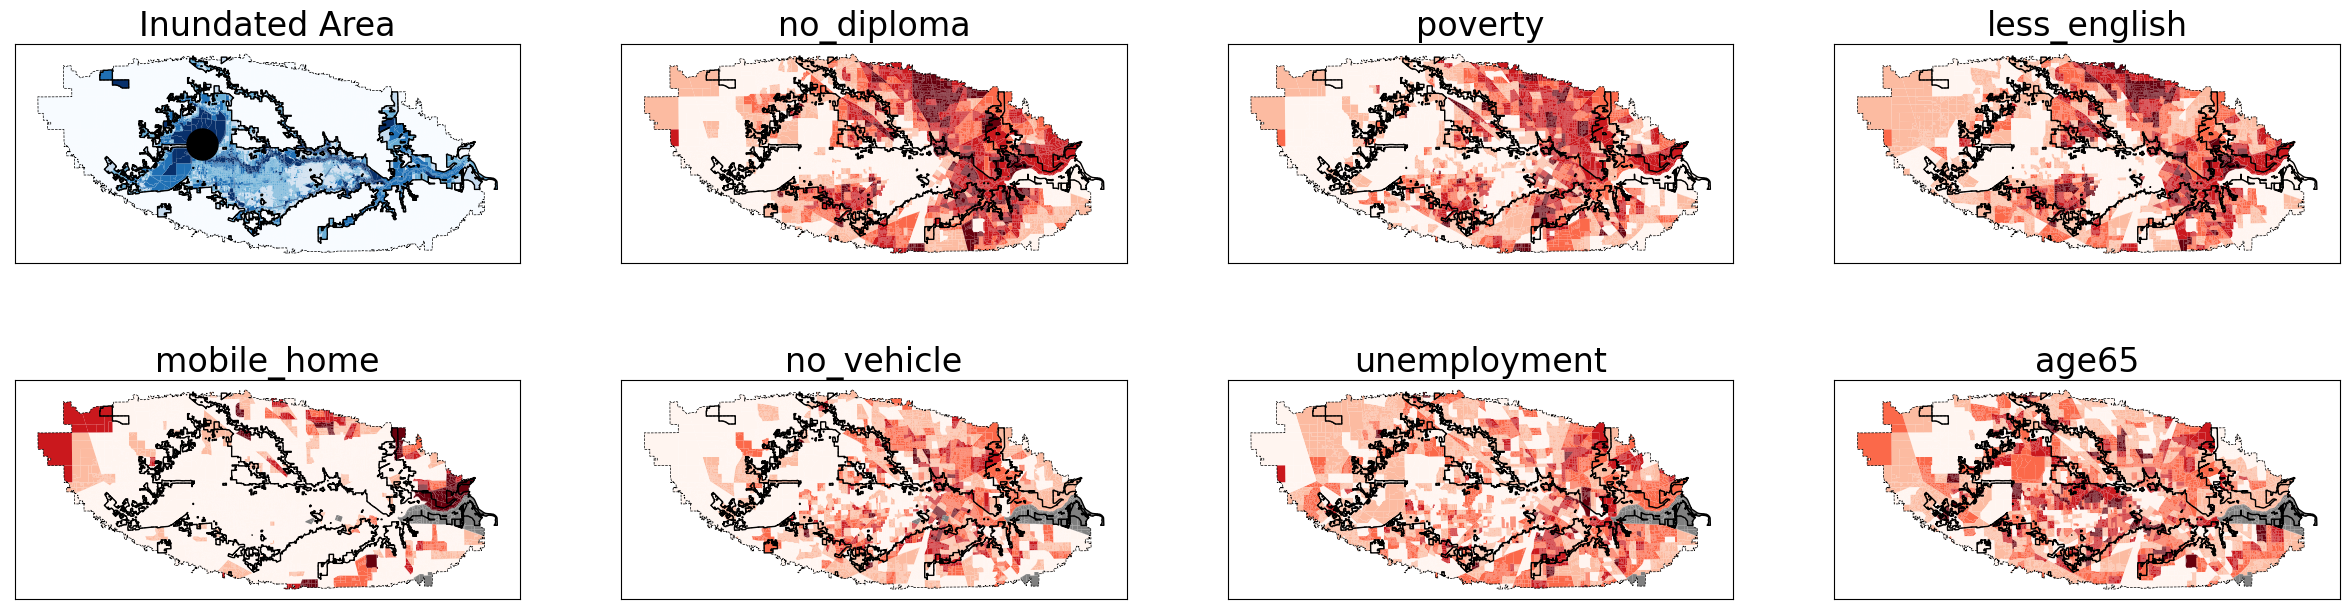

In [34]:
def plot_vulnerability_attribute_around_dam(dam_id, fim_geoid_gdf, dam_df):
    fig, axes = plt.subplots(2, 4, figsize=(30,8))
    ax = axes.reshape(-1)

    # Define geography related to each dam
    dam_area = fim_geoid_gdf.loc[fim_geoid_gdf['Dam_ID'] == dam_id].reset_index()

    benchmark_area = dam_area.loc[dam_area['Class'] == 0]
    inund_area = dam_area.loc[dam_area['Class'] > 0]
    benchmark_area_union = benchmark_area.dissolve(by='Dam_ID')
    inund_area_union = inund_area.dissolve(by='Dam_ID')

    fed_dams_focus = dam_df.loc[dam_df['ID'] == dam_id].reset_index()

    # Plot maps
    var_list = ['no_diploma', 'poverty', 'less_english', 'mobile_home', 'no_vehicle', 'unemployment', 'age65']
    for m in range(8):
        if m == 0:
            fim_geoid_gdf.plot('Class', cmap='Blues', ax=ax[m])
            fed_dams_focus.plot(ax=ax[m], markersize=500, color='black')
            ax[m].set_title(label="Inundated Area", fontsize=24)
        else:
            dam_area.loc[dam_area[var_list[m-1]] != -666666666].plot(var_list[m-1], ax=ax[m], scheme='FisherJenks', cmap='Reds')
            dam_area.loc[dam_area[var_list[m-1]] == -666666666].plot(ax=ax[m], color='Grey')
            ax[m].set_title(label=f"{var_list[m-1]}", fontsize=24)
#             ax[m].set_title(label=f"{var_list[m-1]} ({fed_dams_focus['c_' + var_list[m-1]].values[0]})", fontsize=24)
        benchmark_area_union.boundary.plot(ax=ax[m], color='black', lw=0.5, linestyle='dashed')
        inund_area_union.boundary.plot(ax=ax[m], color='black', lw=1)
        ax[m].get_xaxis().set_visible(False)
        ax[m].get_yaxis().set_visible(False)
        
    plt.show()
    
for dam_id in fed_dams['ID'].unique():
    plot_vulnerability_attribute_around_dam(dam_id, fim_geoid, fed_dams)

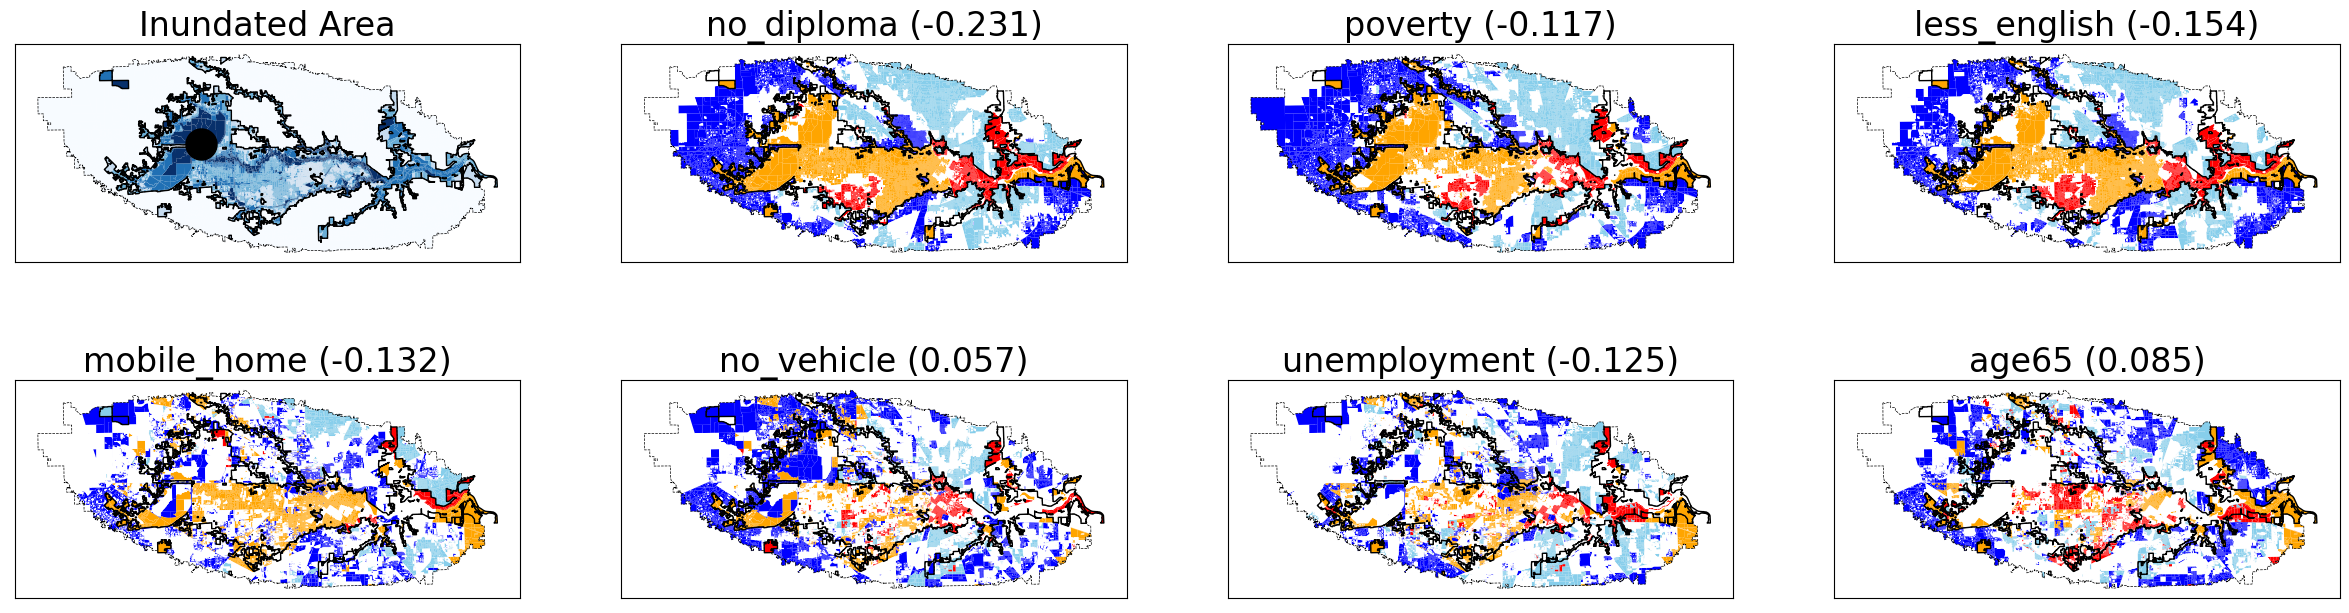

In [35]:
def calculate_bivariate_moran_i(local_fim_geoid_gdf, var):
    w = libpysal.weights.Queen.from_dataframe(local_fim_geoid_gdf)
    bv_mi = esda.Moran_BV(local_fim_geoid_gdf['Class'], local_fim_geoid_gdf[var], w)
    bv_lm = esda.Moran_Local_BV(local_fim_geoid_gdf['Class'], local_fim_geoid_gdf[var], w)
    
    lm_dict = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
    bv_lm_result = []
    for idx in range(len(bv_lm.q)):
        if bv_lm.p_sim[idx] < 0.05:
            bv_lm_result.append(lm_dict[bv_lm.q[idx]])
        else:
            bv_lm_result.append('Not_Sig')

    return round(bv_mi.I, 3), pd.Series(bv_lm_result)
    
def plot_bivariate_moran_i_and_local_moran_i(dam_id, fim_geoid_gdf):
    fig, axes = plt.subplots(2, 4, figsize=(30, 8))
    ax = axes.reshape(-1)

    # Define geography related to each dam
    dam_area = fim_geoid_gdf.loc[fim_geoid_gdf['Dam_ID'] == dam_id].reset_index()

    benchmark_area = dam_area.loc[dam_area['Class'] == 0]
    inund_area = dam_area.loc[dam_area['Class'] > 0]
    benchmark_area_union = benchmark_area.dissolve(by='Dam_ID')
    inund_area_union = inund_area.dissolve(by='Dam_ID')

    fed_dams_focus = fed_dams.loc[fed_dams['ID'] == dam_id].reset_index()
    fed_dams_focus = fed_dams_focus.to_crs(epsg=5070)

    # Plot maps
    var_list = ['no_diploma', 'poverty', 'less_english', 'mobile_home', 'no_vehicle', 'unemployment', 'age65']
    for m in range(8):
        if m == 0:
            fim_geoid_gdf.plot('Class', cmap='Blues', ax=ax[m])
            fed_dams_focus.plot(ax=ax[m], markersize=500, color='black')
            ax[m].set_title(label="Inundated Area", fontsize=24)
        else:
            dam_area_ = dam_area.loc[~dam_area[var_list[m-1]].isna()]
            bi_mi, bi_lm = calculate_bivariate_moran_i(dam_area_, var_list[m-1])
            
            lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'white'}
            fim_geoid_gdf[f'{var}_lm'] = bi_lm
            
            for key in lisa_color.keys():
                fim_geoid_gdf.loc[fim_geoid_gdf[f'{var}_lm'] == key].plot(ax=ax[m], color=lisa_color[key], legend=True)
            
            ax[m].set_title(label=f"{var_list[m-1]} ({bi_mi})", fontsize=24)

        benchmark_area_union.boundary.plot(ax=ax[m], color='black', lw=0.5, linestyle='dashed')
        inund_area_union.boundary.plot(ax=ax[m], color='black', lw=1)
        ax[m].get_xaxis().set_visible(False)
        ax[m].get_yaxis().set_visible(False)
        
    plt.show()
    
for dam_id in fed_dams['ID'].unique():
    plot_bivariate_moran_i_and_local_moran_i(dam_id, fim_geoid_p)